# Project 1 Revisited: Importances and Coefficients

## Task
- For this assignment, you will revisit your first project to predict supermarket sales. You will apply what you've learned this week to explain how your models made their predictions.
### Project 1 Revisited - Part 1: Remaking, Saving, and Explaining Your Models
- For this part of the project, you will be producing a new version of your final project notebook using the updated tools in sklearn v1.1. 

  - Create a new notebook called "Project 1 - Revisited.ipynb" in your project repo.
    - You may either make a copy of your prior notebook that you will modify,
or you can start a new blank notebook and copy over the code from your old notebook (as needed).
- Remake your X_train and X_test as DataFrames with the feature names extracted from the column transformer instead of combining your preprocessor and model into 1 pipeline.
### LinearRegression
- Fit and evaluate your LinearRegresion model using your dataframe X_train and X_test data.
- Extract and visualize the coefficients that your model determined.
  - Select the top 3 most impactful features and interpret their coefficients in plain English.
- Save your figure as a .png file inside your repository (you will need this for the final piece of this assignment - Update Your README).
### Tree-Based Model
- Fit and evaluate your tree-based regression model using your dataframe X_train and X_test data.
- Extract and visualize the feature importances that your model determined.
  - Identify the top 5 most important features.
- Save your figure as a .png file inside your repository  (you will need this for the final piece of this assignment - Update Your README).
### Serialize Your Best Models with Joblib
- Once you've finished updating and explaining your models, you must save the following key: value pairs as a dictionary in a joblib file named "best-models.joblib":
  - "preprocessor": your preprocessing  column transformer
  - "X_train": your training features.
  - "X_test": your test features.
  - "y_train": your training target.
  - "y_test": your test target.
  - "LinearRegression": your best linear regression
  - Your tree-based model's class name: your best tree-based model.
    - e.g. "RandomForestRegressor"/"DecisionTreeRegressor"
- Save your joblib file inside your repository. (You will work with these models again in the next core assignment.)
### Update your README.
- Insert your exported figures from above into your README file. You should have the following:
  - Your LinearRegression coefficients plot.
    - Your interpretation of your coefficients.
  - Your tree-based model's feature importances.
    - Your interpretation of your feature importances. 


# Import Data and split

In [1]:
## Our standard import
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

# ## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
plt.style.use(('ggplot','tableau-colorblind10'))

In [2]:
import sklearn
!python --version
print(f"sklearn version: {sklearn.__version__}")

Python 3.9.15sklearn version: 1.1.3



In [3]:
path = 'Data/sales_predictions.csv'
df = pd.read_csv(path)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [5]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [6]:
# Fixing the description of items "Fat Content"
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg','Regular')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat', 'Low Fat')

df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [7]:
y = df['Item_Outlet_Sales']
X = df.drop(columns=['Item_Outlet_Sales', 'Outlet_Identifier', 'Outlet_Location_Type', 'Item_Identifier'])

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Type
8269,7.220,Regular,0.064142,Baking Goods,61.2510,1998,NaN,Grocery Store
7604,6.135,Low Fat,0.079294,Soft Drinks,111.2860,2009,Medium,Supermarket Type2
2762,12.150,Low Fat,0.028593,Household,151.0708,2004,Small,Supermarket Type1
6464,5.945,Low Fat,0.093009,Household,127.8652,2004,Small,Supermarket Type1
4707,18.200,Regular,0.066285,Fruits and Vegetables,247.2092,2004,Small,Supermarket Type1


In [8]:
## make pipelines for categorical vs numeric data
cat_sel = make_column_selector(dtype_include='object')
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))

num_sel = make_column_selector(dtype_include='number')
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))


## make the preprocessing column transformer with verbose_feature_names_out=False
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001DCE2C632B0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001DCE2C63160>)],
                  verbose_feature_names_out=False)

In [9]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)

X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_High,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
8077,15.25,0.061531,132.2968,2007.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2391,17.85,0.044463,127.1020,1997.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
163,7.27,0.071078,114.2518,1997.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [10]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit-learn-compatible regression model using r-squared and RMSE

    Args:
        model (Regressor): Regression Model with a .predict method
        X_train (DataFrame): Training Features
        y_train (Series): Training Target
        X_test (DataFrame): Test Features
        y_test (Series): Test Target
    """

    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

# LinearRegresion model

In [11]:
## fitting a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_df, y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.56	RMSE= 1115.40
Test Data:	R^2= 0.56	RMSE= 1164.52


In [12]:
# lin_reg.coef_

In [13]:
## Checking the number of coeffs matches the # of feature names
# print(len(lin_reg.coef_))
# len(feature_names)

In [14]:
## Saving the coefficients
# coeffs = pd.Series(lin_reg.coef_, index= feature_names)
# coeffs

In [15]:
# use .loc to add the intercept to the series
# coeffs.loc['intercept'] = lin_reg.intercept_
# coeffs

In [16]:
def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

In [17]:
coeffs = get_coefficients(lin_reg)
coeffs

Item_Weight                            1.087961
Item_Visibility                     -264.186859
Item_MRP                              15.593866
Outlet_Establishment_Year             19.039494
Item_Fat_Content_Low Fat             -15.350851
Item_Fat_Content_Regular              15.350851
Item_Type_Baking Goods                 8.845751
Item_Type_Breads                      -4.381286
Item_Type_Breakfast                   70.466930
Item_Type_Canned                      22.688608
Item_Type_Dairy                      -47.897124
Item_Type_Frozen Foods                -5.161859
Item_Type_Fruits and Vegetables       15.778411
Item_Type_Hard Drinks                 45.506443
Item_Type_Health and Hygiene         -41.149870
Item_Type_Household                  -69.797691
Item_Type_Meat                       -16.071190
Item_Type_Others                      19.974397
Item_Type_Seafood                     99.718381
Item_Type_Snack Foods                -11.102988
Item_Type_Soft Drinks               -117

In [18]:
## formatting numbers to not use , thousands sep, and 4 digits floats
pd.set_option('display.float_format',lambda x: f"{x:,.4f}")
pd.set_option('display.max_rows', None)

In [19]:
coeffs.sort_values()

intercept                         -38,066.3473
Outlet_Type_Grocery Store          -1,553.6001
Outlet_Type_Supermarket Type2        -378.4236
Item_Visibility                      -264.1869
Outlet_Size_MISSING                  -188.9594
Item_Type_Soft Drinks                -117.3100
Item_Type_Household                   -69.7977
Item_Type_Dairy                       -47.8971
Item_Type_Health and Hygiene          -41.1499
Outlet_Size_Small                     -19.6571
Item_Type_Meat                        -16.0712
Item_Fat_Content_Low Fat              -15.3509
Item_Type_Snack Foods                 -11.1030
Item_Type_Frozen Foods                 -5.1619
Item_Type_Breads                       -4.3813
Item_Weight                             1.0880
Outlet_Size_Medium                      4.7651
Item_Type_Baking Goods                  8.8458
Item_Fat_Content_Regular               15.3509
Item_MRP                               15.5939
Item_Type_Fruits and Vegetables        15.7784
Outlet_Establ

In [20]:
## Get a list of all of the ohe columns
item_feats = [c for c in X_train_df.columns if c.startswith('Item_Type')]
len(item_feats)

16

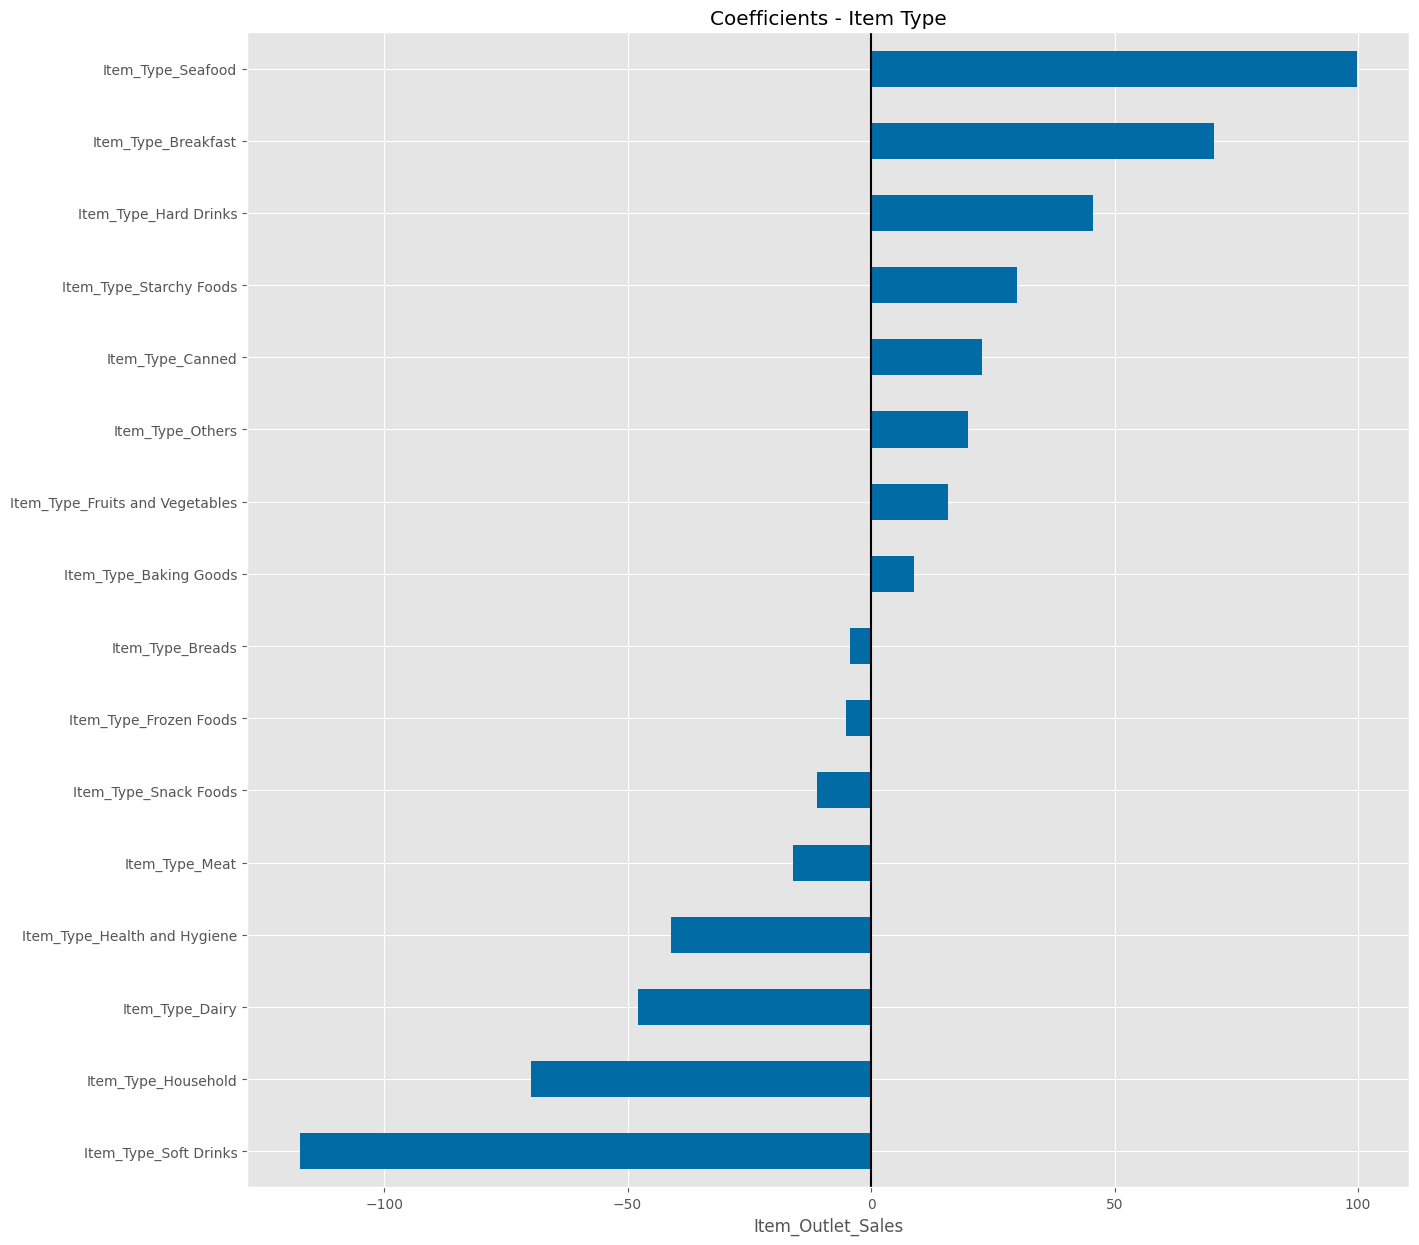

In [21]:
## Plot coeffs
ax = coeffs[item_feats].sort_values().plot(kind='barh', figsize=(15,15))
ax.axvline(0, color='k')
ax.set(xlabel='Item_Outlet_Sales', title="Coefficients - Item Type");

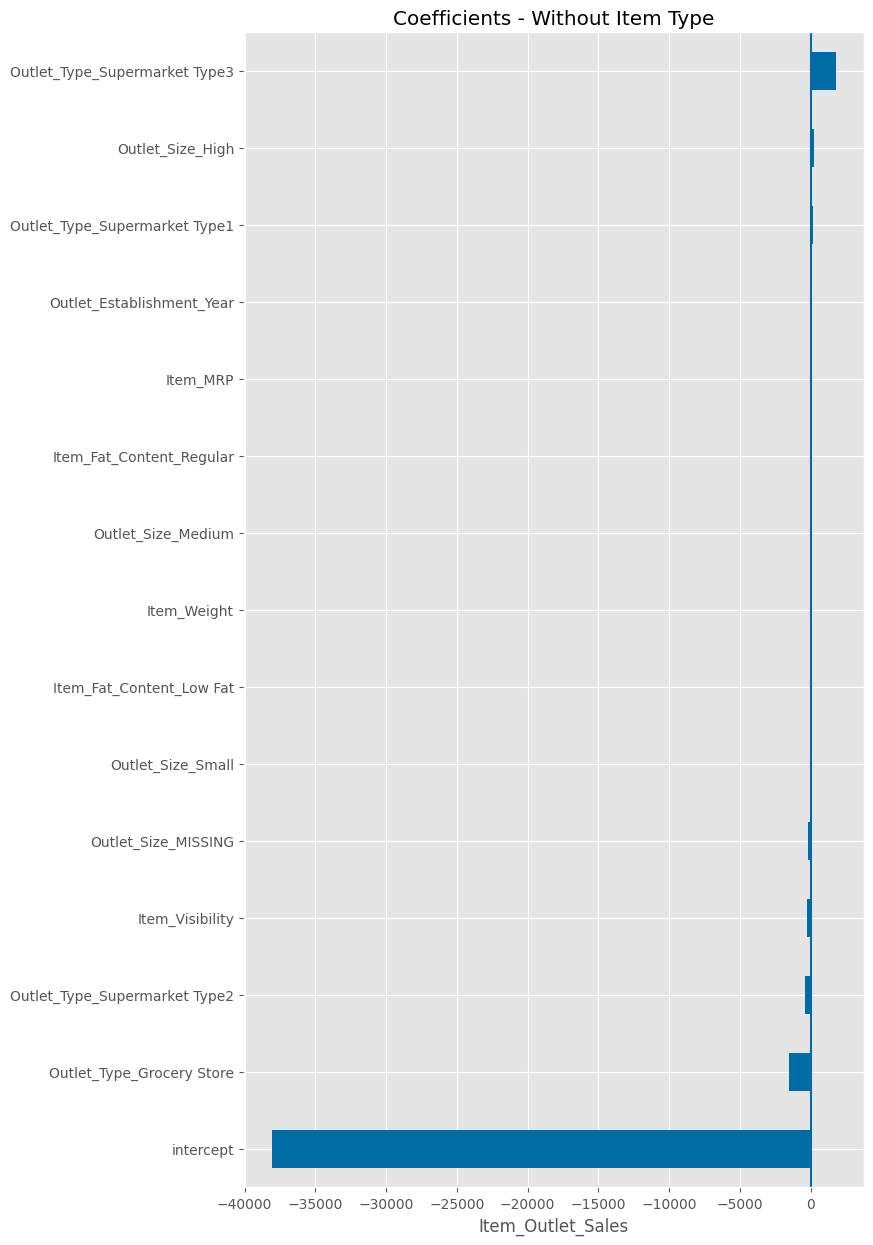

In [28]:
## Plot everything but item identifier
ax = coeffs.drop(item_feats).sort_values().plot(kind='barh', figsize=(8,15))
ax.axvline(0)
ax.set(xlabel='Item_Outlet_Sales', title="Coefficients - Without Item Type");

plt.savefig('Data/coeffs.png')

## Three most impactful features:
1. Outlet Type "Supermarket Type3":
  - Being the highest coefficient indicates that stores of this size tend to have more sales overall. 
2. Outlet Size High:
  - Items in a larger store seem to do better overall.
3. Outlet Type "Supermarket Type1":
 - Looking at the graph these types of stores tend to sell more items than others.

# Tree-Based Model

In [23]:
reg = RandomForestRegressor(random_state=SEED)
reg.fit(X_train_df,y_train)
evaluate_regression(reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.94	RMSE= 426.87
Test Data:	R^2= 0.56	RMSE= 1169.09


In [24]:
## Saving the coefficients
importances = pd.Series(reg.feature_importances_, index= reg.feature_names_in_)
importances

Item_Weight                       0.0534
Item_Visibility                   0.1007
Item_MRP                          0.4480
Outlet_Establishment_Year         0.0398
Item_Fat_Content_Low Fat          0.0050
Item_Fat_Content_Regular          0.0048
Item_Type_Baking Goods            0.0045
Item_Type_Breads                  0.0030
Item_Type_Breakfast               0.0025
Item_Type_Canned                  0.0042
Item_Type_Dairy                   0.0056
Item_Type_Frozen Foods            0.0057
Item_Type_Fruits and Vegetables   0.0082
Item_Type_Hard Drinks             0.0029
Item_Type_Health and Hygiene      0.0043
Item_Type_Household               0.0062
Item_Type_Meat                    0.0037
Item_Type_Others                  0.0016
Item_Type_Seafood                 0.0015
Item_Type_Snack Foods             0.0079
Item_Type_Soft Drinks             0.0042
Item_Type_Starchy Foods           0.0028
Outlet_Size_High                  0.0032
Outlet_Size_MISSING               0.0060
Outlet_Size_Medi

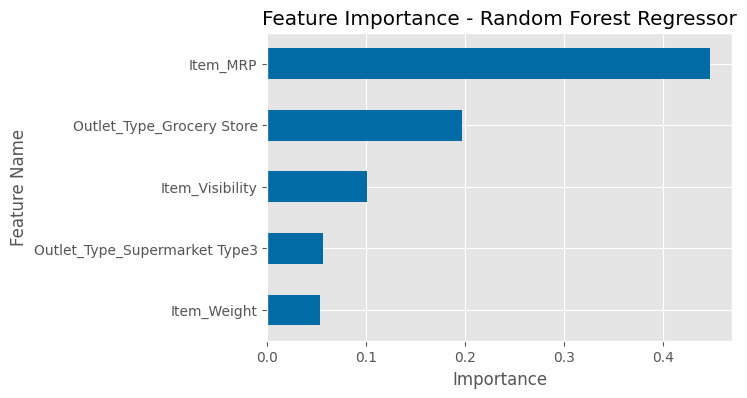

In [25]:
ax = importances.sort_values().tail(5).plot(kind='barh',figsize=(6,4))
ax.axvline(0, color='k')
ax.set(title='Feature Importance - Random Forest Regressor',ylabel="Feature Name",
      xlabel='Importance');

plt.savefig('Data/importances.png', bbox_inches="tight")

## Five most important features.
1. Item Market retail Price
 - This goes without saying, the item price is a big factor in outlet sales.
2. Outlet Type "Grocery Store"
 - Being a grocery store would bring in more sales as food is consistently being replaced and purchased on a regular basis.
3. Item Visibility
 - Visually appealing and grabbing customers attention and "persuading" the purchase of the item.
4. Outlet type "Supermarket Type 3"
 - Perhaps this size of store hold more items than others and generates more overall sales.
5. Outlet Establishment Year
 - The year a store was built may have an impact on the amount of sales, maybe more convenience for customers?.

# Serialize Our Best Model with Joblib

In [26]:
reg = RandomForestRegressor(random_state=SEED)
reg.fit(X_train_df,y_train)
evaluate_regression(reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.94	RMSE= 426.87
Test Data:	R^2= 0.56	RMSE= 1169.09


In [27]:
## saving variables for next lesson/notebook
import joblib
## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train_df,
         'y_train': y_train,
         'X_test':X_test_df,
          "y_test": y_test,
         'preprocessor':preprocessor,
         'RandomForest':reg}
joblib.dump(export, 'random_forest_l01.joblib')

['random_forest_l01.joblib']